In [25]:
from food_web_core.utility_functions import *
from food_web_core.size_based_ecosystem import *
import imageio
from mpl_toolkits.axes_grid1 import ImageGrid

In [26]:
from scipy.special import lambertw
def detection_dist(light, k, K, c):
    return np.real(2*lambertw(k/2* np.sqrt(light/c*(K+light)))/k)

In [27]:
tz = 'Europe/Vatican'
name = 'Oresund'
start_date = '2014-04-01'
end_date = '2014-10-01'
freq = '15Min'

In [28]:
def sketch_plotter(eco, strats, resources, time):
    day_interval = 96
    fig, ax = plt.subplots(1,1,)
    
    ax.fill_between(2*eco.spectral.x, 0.5*strats[time][0]@eco.heat_kernels[0], y2 = 0, alpha = 0.5, color = 'blue')
    ax.fill_between(2*eco.spectral.x, 0.5*strats[time][1]@eco.heat_kernels[0], y2 = 0, alpha = 0.5, color = 'red')
    ax.fill_between(2*eco.spectral.x, 0.5*resources, y2 = 0, alpha = 0.5, color = 'yellow')

    ax.set_xlabel("Depth in m")
    ax.set_ylim((0, 25))
    ax.xaxis.set_major_locator(plt.MultipleLocator(30))
    ax.set_ylabel("\% of biomass")
    fig.tight_layout()
    plt.savefig("sketch_for_article" + ".pdf")

In [29]:
dates = pd.date_range(start=start_date, end=end_date, freq=freq, tz=tz)

In [30]:
def dist_plotter(eco, strats, times, filename = None):
    day_interval = 96
    fig, ax = plt.subplots(1,len(times), sharex='col', sharey = 'row')
    fig.set_size_inches((12/2.54, 6/2.54))
    
    new_vec = np.linspace(0,45,200)

    
    for i, time in enumerate(times):
        ax[i].fill_between(2*eco.spectral.x, 0.5*strats[time][0]@eco.heat_kernels[0], y2 = 0, alpha = 0.5, color = 'blue')
        ax[i].fill_between(2*eco.spectral.x, 0.5*strats[time][1]@eco.heat_kernels[0], y2 = 0, alpha = 0.5, color = 'red')
        ax[i].set_xlabel("("+str(i+1)+")"+" Depth in m")
        ax[i].set_ylim((0, 20))
        ax[i].xaxis.set_major_locator(plt.MultipleLocator(30))
    ax[0].set_ylabel("\% of biomass")
    fig.tight_layout()
    plt.savefig("specific_dists_" + filename + ".pdf")

In [31]:
new_spectral = spectral_method(30, 200)

In [32]:
def expander(old_spectral, new_spectral, transform_vec):
    length = old_spectral.x[-1]
    coeffs = np.linalg.inv(old.spectral.JacobiP_n(2*old_spectral.x/length - 1, 0, 0, old_spectral.n).T) @ transform_vec
    transformer = new_spectral.JacobiP_n(2*new_spectral.x/new_spectral.x[-1] - 1, 0, 0, old_spectral.n).T
    return transformer @ coeffs

In [33]:
solar_levels = solar_input_calculator()
solar_levels = solar_levels/np.max(solar_levels)

In [34]:
def interpolater(spectral, new_points, transform_vec):
    length = spectral.x[-1]
    coeffs = np.linalg.inv(spectral.JacobiP_n(2*spectral.x/length - 1, 0, 0, spectral.n).T) @ transform_vec
    transformer = spectral.JacobiP_n(2*new_points/new_points[-1] - 1, 0, 0, spectral.n).T
    return transformer @ coeffs

In [35]:
import matplotlib.pyplot as plt
import pickle as pkl
import imageio as imageio
frames_path = "images/images" + "{i}.jpg"
gif_path = "images/test_gif.gif"

In [51]:
def data_extractor(filenames, path = 'data/'):
    strategies = []
    populations = []
    eco = []
    resources = []
    for text in filenames:
        with open(path + text + 'strategies' +  '.pkl', 'rb') as f:
            strategies.append(np.array(pkl.load(f)))
        with open(path + text + 'population' +  '.pkl', 'rb') as f:
            populations.append(np.array(pkl.load(f)))
        with open(path + text + 'eco' +  '.pkl', 'rb') as f:
            eco.append(pkl.load(f))
        with open(path + text + 'resource' +  '.pkl', 'rb') as f:
            resources.append(np.array(pkl.load(f)))
    populations[0] = np.array(populations[0])
    populations[1] = np.array(populations[1])
    populations[2] = np.array(populations[2])

    strategies[0] = np.array(strategies[0])
    strategies[1] = np.array(strategies[1])
    strategies[2] = np.array(strategies[2])
    
    
    resources[0] = np.array(resources[0])
    resources[1] = np.array(resources[1])
    resources[2] = np.array(resources[2])
    return strategies, populations, resources, eco


In [52]:
filenames = ['non_random_oresund', 'more_random_oresund', 'completely_random_oresund']

In [53]:
strategies, populations, resources, ecos = data_extractor(filenames)

In [58]:
A = np.zeros((ecos[0].populations.size, ecos[0].populations.size * ecos[0].layers))
for k in range(ecos[0].populations.size):
    A[k, k * ecos[0].layers:(k + 1) * ecos[0].layers] = -1


In [59]:
payoff_matrix = total_payoff_matrix_builder(ecos[0])

In [60]:
H = np.block([[-payoff_matrix, A.T], [-A, np.zeros((A.shape[0], ecos[0].populations.size))]])


In [68]:
np.linalg.eig(H)[0]

array([ 8.40492845e+05  +0.j        , -7.22892857e-11+290.47550885j,
       -7.22892857e-11-290.47550885j,  4.83487575e+01+263.94811828j,
        4.83487575e+01-263.94811828j,  1.17460058e+02  +0.j        ,
        1.05537246e-11 +47.193843j  ,  1.05537246e-11 -47.193843j  ,
        1.05665298e+00 +43.74154804j,  1.05665298e+00 -43.74154804j,
        2.96840330e-12 +26.26133777j,  2.96840330e-12 -26.26133777j,
        1.07451974e-01 +24.94235734j,  1.07451974e-01 -24.94235734j,
       -8.03858369e-12 +18.23457618j, -8.03858369e-12 -18.23457618j,
       -4.71934087e-02 +17.52765543j, -4.71934087e-02 -17.52765543j,
        5.52992374e-12 +13.99799317j,  5.52992374e-12 -13.99799317j,
       -8.49898133e-02 +13.55120511j, -8.49898133e-02 -13.55120511j,
       -2.85632629e-13 +11.38582102j, -2.85632629e-13 -11.38582102j,
       -9.44125581e-02 +11.07471593j, -9.44125581e-02 -11.07471593j,
       -8.29281088e-13  +9.61860304j, -8.29281088e-13  -9.61860304j,
       -9.53906933e-02  +9.3879334

In [14]:
interpolated = interpolater(ecos[0].spectral, np.linspace(0,45,100), strategies[0][13000][0]@ecos[0].heat_kernels[0])

In [15]:

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size = 10)
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120), 
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150), 
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148), 
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199), 
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)



In [16]:
import matplotlib.colorbar
def heatmap_plotter(data, image_name, ext, sigmas = ["0", "10", "$\infty$"]):
    fig = plt.figure(figsize=(12/2.54, 12/2.54))
    times = ["12 ", "18", "24", "06", "12"]

    grid = ImageGrid(fig, 111,  # as in plt.subplot(111)
                     nrows_ncols=(1, len(data)),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="5%",
                     cbar_pad=0.05,
                     
                     )

    # Add data to image grid
    i = 0
    for ax in grid:
        im = ax.imshow(data[i], vmin=0, cmap='viridis', extent=ext)
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        ax.set_aspect((x1 - x0) / (y1 - y0))
        ax.set_xlabel("(" + str(i+1) + ") " + "$\sigma$ = " + sigmas[i] + " m$^2$")
        ax.set_ylabel("Depth (m)")
        ax.set_xticks([-12,-6, 0, 6, 12]) #xaxis.set_major_locator(plt.MultipleLocator(4))
        ax.set_xticklabels(times)

        i += 1
    
    # Colorbar
    #ax.cax.colorbar(im)
    #thecb = #ax.cax.colorbar(im)
    ax.cax.cla() 
    thecb = matplotlib.colorbar.Colorbar(ax.cax,im)
    #thecb.set_labelpad(15)
    thecb.set_label("\% of biomass", rotation = 270, labelpad = 12)
    ax.cax.toggle_label(True)
    #ax.cax.set_label('\% of biomass')
    #plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
    #fig.colorbar(im, cax=cax)

    plt.savefig(image_name+".pdf", bbox_inches='tight')

def bigge_heatmap_plotter(day, eco, strategy_data, fineness = 100, filename = None):
    day_interval = 96
    day = int(day*day_interval)
    new_vec = np.linspace(0,45,fineness)
    HM_C = np.zeros((fineness, 96))
    HM_P = np.zeros((fineness, 96))
    for i in range(day,day+day_interval):
        HM_C[:, i-(day)] = interpolater(eco.spectral, new_vec, 100*strategy_data[i][0]@eco.heat_kernels[0])
        HM_P[:, i-(day)] = interpolater(eco.spectral, new_vec, 100*strategy_data[i][1]@eco.heat_kernels[0])
    heatmap_plotter([HM_C, HM_P], "heatmaps" + filename , [-12, 12, -90, 0])


In [17]:
"\sigma"

'\\sigma'

In [17]:
time = 96*10+48
normalized_resources = resources[0][time]/np.sum(ecos[0].spectral.M @ resources[0][time])
sketch_plotter(ecos[0], 100*strategies[0], 100*normalized_resources, int(time))

NameError: name 'resources' is not defined

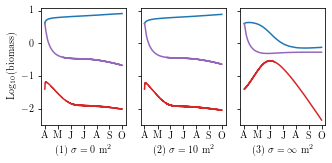

In [18]:
time = np.linspace(0, int(populations[0].shape[0]/96), populations[0].shape[0])


length_of_months = [0, 31, 30+31, 31+31+30, 31+31+31+30, 30+ 31+31+31+30, 31+31+31+30+31+29]
fig, ax = plt.subplots(1, 3, sharex='col', sharey = 'row')
fig.set_size_inches((12/2.54, 6/2.54))

ax[0].plot(time, np.log10(populations[0][:,0]), color = tableau20[0], label = '20g fish')
ax[0].plot(time, np.log10(populations[0][:,1]), color = tableau20[6], label = '8000g fish')
ax[0].set_xticks(length_of_months)
ax[0].set_xticklabels(['A','M','J','J', 'A', 'S', 'O'])


ax[1].plot(time, np.log10(populations[1][:,0]), color = tableau20[0], label = '20g fish')
ax[1].plot(time, np.log10(populations[1][:,1]), color = tableau20[6], label = '8000g fish')
ax[1].set_xticks(length_of_months)
ax[1].set_xticklabels(['A','M','J','J', 'A', 'S', 'O'])


ax[2].plot(time, np.log10(populations[2][:,0]), color = tableau20[0], label = '20g fish')
ax[2].plot(time, np.log10(populations[2][:,1]), color = tableau20[6], label = '8000g fish')
ax[2].set_xticks(length_of_months)
ax[2].set_xticklabels(['A','M','J','J', 'A', 'S', 'O'])


ax[0].plot(time, np.log10(ecos[0].spectral.M.sum(axis = 1) @ resources[0].T), color = tableau20[8])
ax[1].plot(time, np.log10(ecos[0].spectral.M.sum(axis = 1) @ resources[1].T), color = tableau20[8])
ax[2].plot(time, np.log10(ecos[0].spectral.M.sum(axis = 1) @ resources[2].T), color = tableau20[8])
ax[2].set_xticks(length_of_months)
ax[2].set_xticklabels(['A','M','J','J', 'A', 'S', 'O'])


ax[0].set_ylabel("Log$_{10}$(biomass)")
ax[0].set_xlabel("(1) $\sigma=0$ m$^2$")
ax[1].set_xlabel("(2) $\sigma=10$ m$^2$")
ax[2].set_xlabel("(3) $\sigma=\infty$ m$^2$")
fig.tight_layout()
plt.savefig("populations.pdf")

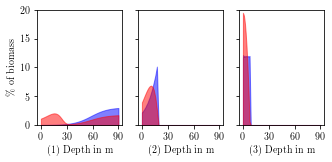

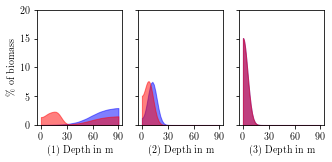

In [19]:
dist_plotter(ecos[0], 100*strategies[0], [96*179+48, 96*179+75, 96*180], filename = "rational")
dist_plotter(ecos[1], 100*strategies[1], [96*179+48, 96*179+75, 96*180], filename = "semi_rational")


In [58]:
ecos[0].parameters.loss_term

array([ 0.23579379, 21.40560409])

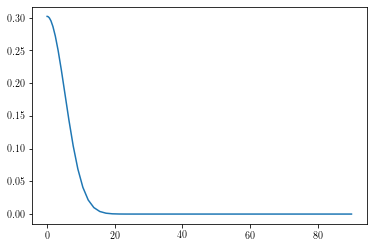

In [55]:
plt.plot(2*ecos[0].spectral.x, strategies[1][96*180,1]@ecos[1].heat_kernels[0])

In [20]:
ecos[0].water.res_counts = ecos[0].water.res_counts/10

(0.0, 1.0)

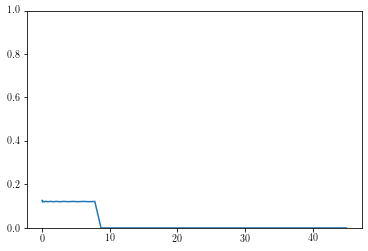

In [21]:
plt.plot(ecos[0].spectral.x, lemke_optimizer(ecos[0])[0:60]@ecos[0].heat_kernels[0])
plt.ylim((0,1))

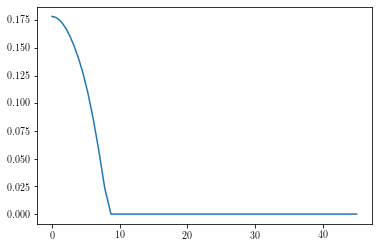

In [22]:
plt.plot(ecos[0].spectral.x, lemke_optimizer(ecos[0])[60:120]@ecos[0].heat_kernels[0])

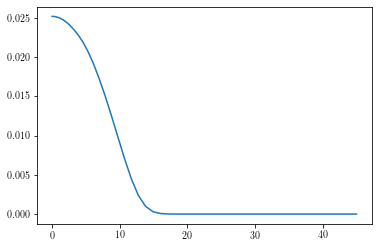

In [23]:
plt.plot(ecos[0].spectral.x, resources[0][-1])

In [24]:
strategies[0].shape

(17569, 2, 60)

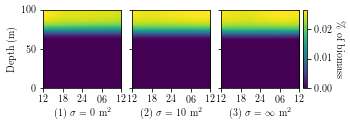

In [25]:
heatmap_plotter([resources[0][10*96:11*96].T, resources[0][90*96:91*96].T, resources[0][180*96:181*96].T], "resource_dist", [-12, 12, 0, 100])

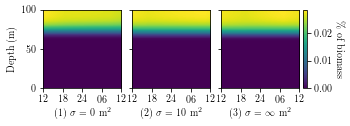

In [26]:
heatmap_plotter([resources[1][10*96:11*96].T, resources[1][90*96:91*96].T, resources[1][180*96:181*96].T], "resource_dist", [-12, 12, 0, 100])

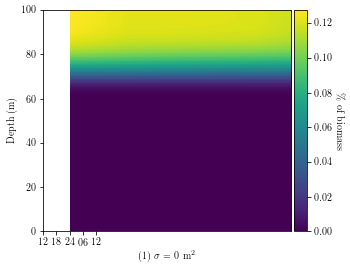

In [27]:
heatmap_plotter([resources[0][10*96:11*96].T], "resource_dist", [0, 100, 0, 100])

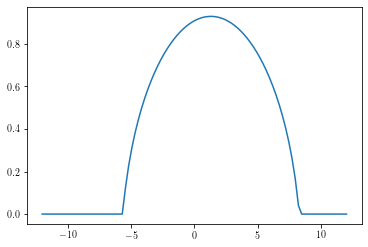

In [28]:
plt.plot(np.linspace(-12,12,96), solar_levels[10*96:11*96])

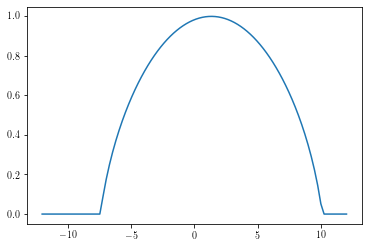

In [29]:
plt.plot(np.linspace(-12,12,96), solar_levels[90*96:91*96])

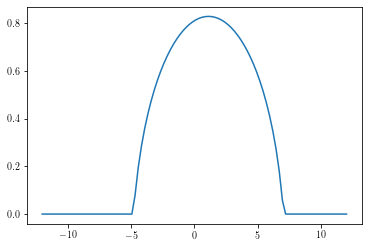

In [30]:
plt.plot(np.linspace(-12,12,96), solar_levels[180*96:181*96])

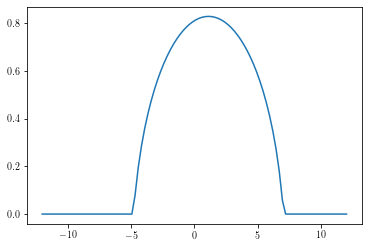

In [31]:
plt.plot(np.linspace(-12,12,96), solar_levels[180*96:181*96])

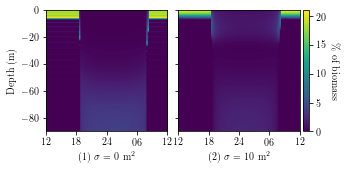

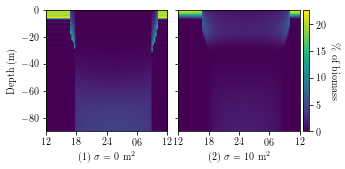

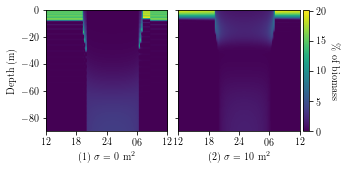

In [32]:
bigge_heatmap_plotter(10, ecos[0], strategies[0]/2, fineness = 200, filename = "day10_nonrandom")
bigge_heatmap_plotter(90, ecos[0], strategies[0]/2, fineness = 200, filename = "day90_nonrandom")
bigge_heatmap_plotter(180, ecos[0], strategies[0]/2, fineness = 200, filename = "day180_nonrandom")

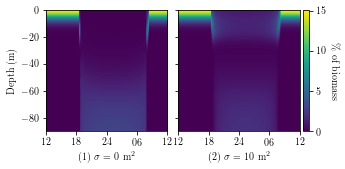

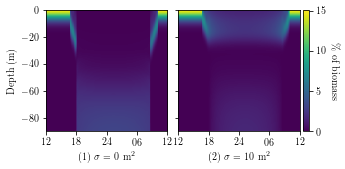

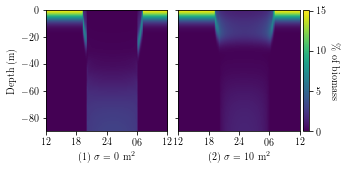

In [33]:
bigge_heatmap_plotter(10, ecos[1], strategies[1]/2, fineness = 200, filename = "day10_semirandom")
bigge_heatmap_plotter(90, ecos[1], strategies[1]/2, fineness = 200, filename = "day90_semirandom")
bigge_heatmap_plotter(180, ecos[1], strategies[1]/2, fineness = 200, filename = "day180_semirandom")

In [34]:
def short_term_plotter_population(days, eco, solar_levels, populations, resources, strats, filename = None, sigmas = ["0", "10", "$\infty$"]):
    day_interval = 96
    fig, ax = plt.subplots(1, len(days), sharex='col', sharey = 'row')
    fig.set_size_inches((12/2.54, 6/2.54))
    times = ["12 ", "18", "24", "06", "12"]

    for j, day in enumerate(days):
        
        ax[j].plot(np.linspace(-12,12,day_interval), (populations[day*day_interval:day*day_interval+day_interval,0] - populations[day*day_interval,0])/populations[day*day_interval,0], color = tableau20[0], label = '20g fish')
        ax[j].plot(np.linspace(-12,12,day_interval), (populations[day*day_interval:day*day_interval+day_interval,1] - populations[day*day_interval,1])/populations[day*day_interval,1], color = tableau20[6], label = '8000g fish')
        
        ax[j].set_xticks([-12,-6, 0, 6, 12]) #xaxis.set_major_locator(plt.MultipleLocator(4))
        ax[j].set_xticklabels(times)

        ax[j].set_xlabel("(" + str(j+1) + ") " + "$\sigma$ = " + sigmas[j]+ " m$^2$")

    ax[0].set_ylabel('$\Delta$ Population/Total')

    ax[-1].set_xlim((-12,12))
    fig.tight_layout()
    
    plt.savefig("pop_short_"+filename + ".pdf")

In [35]:
import datetime

In [36]:
def short_term_plotter_pop_compare(day, populations, filename = None, sigmas = ["0", "7", "$\infty$"]):
    day_interval = 96
    fig, ax = plt.subplots(1, len(populations), sharex='col', sharey = 'row')
    fig.set_size_inches((12/2.54, 6/2.54))
    times = ["12 ", "18", "24", "06", "12"]

    for j, population in enumerate(populations):
        
        ax[j].plot(np.linspace(-12,12,day_interval), (population[day*day_interval:day*day_interval+day_interval,0] - population[day*day_interval,0])/population[day*day_interval,0], color = tableau20[0], label = '20g fish')
        ax[j].plot(np.linspace(-12,12,day_interval), (population[day*day_interval:day*day_interval+day_interval,1] - population[day*day_interval,1])/population[day*day_interval,1], color = tableau20[6], label = '8000g fish')

        ax[j].set_xticks([-12,-6, 0, 6, 12]) #xaxis.set_major_locator(plt.MultipleLocator(4))
        ax[j].set_xticklabels(times)
        ax[j].set_xlabel("(" + str(j+1) + ") " + "$\sigma$ = " + sigmas[j] + " m$^2$")

    ax[0].set_ylabel('$\Delta$ Population/Total')

    ax[-1].set_xlim((-12,12))
    fig.tight_layout()
    plt.savefig("pop_dyn_comp_"+filename + ".pdf")

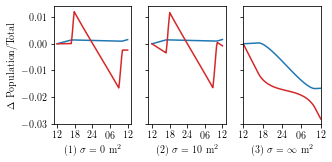

In [37]:
short_term_plotter_pop_compare(90, populations, "full_semi_none")

In [38]:
def short_term_plotter_growth(days, eco, solar_levels, populations, resources, strats, filename = None, day_name = ["May 1", "July 1", "October 1"]):
    day_interval = 96
    fig, ax = plt.subplots(1, len(days), sharex='col', sharey = 'row')
    fig.set_size_inches((12/2.54, 6/2.54))
    times = ["12 ", "18", "24", "06", "12"]
    for j, day in enumerate(days):
        day_ind = int(day*day_interval)
        eco_params_orig = ecosystem_parameters(eco.parameters.mass_vector, eco.spectral)
        OG_layered_attack = eco_params_orig.layered_attack.copy()
        flows = np.zeros((day_interval, 2))

        flows_more_res = np.zeros((day_interval, 2))

        for i in range(day_ind, day_ind+day_interval):
            layered_attack = new_layer_attack(eco_params_orig, solar_levels[i],  k = 0.2)
            T_G = graph_builder(eco, layered_attack = layered_attack, 
                          populations=populations[i], resources = resources[i],
                          strategies = strats[i])
            flows[i-(day_ind), 0] = T_G[1,0]
            flows[i-(day_ind), 1] = T_G[2,1]
            if np.abs(i-2928)<10**(-3):
                print(T_G)
            
        ax[j].plot(np.linspace(-12,12,day_interval), flows[:,0], color = tableau20[0], label = '20g fish')
        ax[j].plot(np.linspace(-12,12,day_interval), flows[:,1], color = tableau20[6], label = '8000g fish')
        ax[j].set_xlabel("(" + str(j+1) + ") " + day_name[j])
        ax[j].set_xticks([-12,-6, 0, 6, 12]) #xaxis.set_major_locator(plt.MultipleLocator(4))
        ax[j].set_xticklabels(times)

        
    ax[0].set_ylabel('Growth, g $\cdot$ year$^{-1}$')

    ax[-1].set_xlim((-12,12))
    fig.tight_layout()
    plt.savefig("growth_short_"+filename + ".pdf")

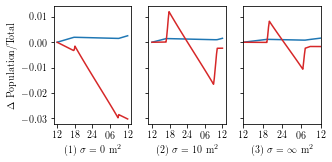

In [39]:
short_term_plotter_population([30, 90, 180], ecos[0], solar_levels, populations[0], resources[0], strategies[0], filename = "rational")

[[0.         0.         0.        ]
 [0.01017632 0.         0.        ]
 [0.         2.08647535 0.        ]]


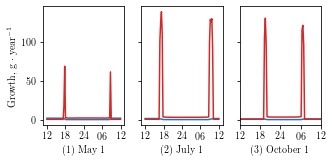

In [40]:
short_term_plotter_growth([30, 90, 180], ecos[0], solar_levels, populations[0], resources[0], strategies[0], filename = "rational")

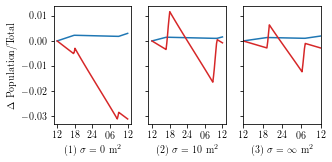

In [41]:
short_term_plotter_population([30, 90, 180], ecos[1], solar_levels, populations[1], resources[1], strategies[1], filename="semi_rational")

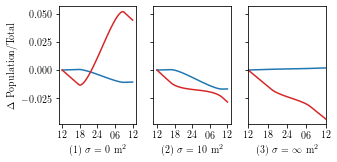

In [42]:
short_term_plotter_population([30, 90, 180], ecos[0], solar_levels, populations[2], resources[2], strategies[2], filename = "irrational")

In [43]:
new_spectral_obj = spectral_method(30, 120, segments = 1)

In [44]:
for i in range(day,day+day_interval):
    plt.figure(figsize=(4,4))
    plt.title("Sunlight:" + str(1/2*(1+min(max((2+1)*np.cos(i*2*np.pi/day_interval), -1), 1))))
    plt.plot(eco.spectral.x*3.3, np.diff(np.cumsum(eco.spectral.M @ (strategies[i][0]@eco.heat_kernels[0])), prepend = np.array([0])), color = 'blue')
    plt.plot(eco.spectral.x*3.3, np.diff(np.cumsum(eco.spectral.M @ (strategies[i][1]@eco.heat_kernels[0])), prepend = np.array([0])), color = 'red')
    plt.plot(eco.spectral.x*3.3,  np.diff(np.cumsum(eco.spectral.M @ resources[i]) , append = np.array([0])))
    plt.ylim((0,1))
    plt.savefig("images/images" + str(i) +".jpg")

    plt.close()

NameError: name 'day' is not defined

In [ ]:
with imgio.get_writer(gif_path, mode='I', fps = 5) as writer:
    for i in range(day, day+day_interval):
        writer.append_data(imgio.imread(frames_path.format(i=i)))

In [ ]:
LD_LA = np.zeros((eco.spectral.n, m_a))
for i in range(day,day+day_interval):
    LD_LA[:, i-(day)] = periodic_layers[i-(day)][:,1,0]
heatmap_plotter([LD_LA], "heatmaps_LA", [0, 24, -100, 0])

In [ ]:
plt.plot(np.log10(np.sum(np.array(resources) @ eco.spectral.M, axis = 1)))

In [ ]:
plt.plot(eco.water.res_counts)

In [ ]:
np.sum(theoretical_max @ eco.spectral.M)